In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import os
# os.listdir("C:\\Users\\Mukul\\Documents\\docker\ files\\ee981")
# os.listdir('/mnt/c/Users/Mukul/Documents/docker files/ee981')

In [3]:
from PIL import Image
import glob
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2 #MobileNetV3Large
from tensorflow.keras.layers import Conv2D, concatenate, Input, BatchNormalization, Conv2DTranspose
# from tensorflow.keras.models import Model
import sklearn as skl
import matplotlib.pyplot as plt
import itertools
# from keras_unet_collection import models
import os
import cv2



print("Tensorflow version " + tf.__version__)

# -- TPU code
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# print('Running on TPU ', tpu.cluster_spec().as_dict())

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)

# strategy = tf.distribute.experimental.TPUStrategy(tpu)
# print("REPLICAS: ", strategy.num_replicas_in_sync)


2025-03-30 22:49:15.254623: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-30 22:49:15.277895: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743371355.293064   12812 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743371355.298571   12812 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743371355.316535   12812 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Tensorflow version 2.19.0


# 0.5 - Hyperparameters


In [4]:
BATCH_SIZE = 16
VALIDATION_SPLIT = 0.15
TEST_SPLIT = 0.15
EPOCHS = 30
LEARNING_RATE = 0.001
IMAGE_SIZE = (2160,3840,3) # 3840 or 3480?
TARGET_SIZE = (512 ,512,3)

# 1 - Preprocessing

In [5]:

# RGB_FIRE_PATH  = '/content/drive/MyDrive/Colab Notebooks/Colab files/EE981/Images/'
# MASK_FIRE_PATH = '/content/drive/MyDrive/Colab Notebooks/Colab files/EE981/Masks/'
RGB_FIRE_PATH  = '/mnt/c/Users/Mukul/Documents/docker files/ee981/EE981/Images/'
MASK_FIRE_PATH = '/mnt/c/Users/Mukul/Documents/docker files/ee981/EE981/Masks/'

img_paths = [RGB_FIRE_PATH + 'image_' + str(i) + '.jpg' for i in range(2002)]
mask_paths  = [MASK_FIRE_PATH + 'image_' + str(i) + '.png' for i in range(2002)]



In [6]:
def show_img(*img_paths):
  for img_path in img_paths:
    img = np.array(Image.open(img_path))
    print(np.unique(img))
    plt.imshow(img)
    plt.show()
# show_img(mask_paths[10])

In [7]:
train_paths_x,test_paths_x, train_paths_y, test_paths_y  = skl.model_selection.train_test_split(img_paths, mask_paths, test_size=TEST_SPLIT) # shuffles
zipped_paths = list(zip(train_paths_x,train_paths_y))
test_zipped_paths = list(zip(test_paths_x,test_paths_y))

img_dataset = tf.data.Dataset.from_tensor_slices(zipped_paths)
test_img_dataset = tf.data.Dataset.from_tensor_slices(zipped_paths)

def get_image(filename):
    img = tf.io.read_file(filename[0])
    mask = tf.io.read_file(filename[1])
    img = tf.image.decode_jpeg(img, channels=3)
    mask = tf.image.decode_png(mask)
    img = tf.image.resize(img,(TARGET_SIZE[0],TARGET_SIZE[1]),method ='nearest')
    mask = tf.image.resize(mask,(TARGET_SIZE[0],TARGET_SIZE[1]), method = 'nearest')
    return (img, mask)

img_dataset = img_dataset.map(get_image)
img_dataset = img_dataset.batch(BATCH_SIZE)

test_dataset = test_img_dataset.map(get_image)
test_dataset = test_dataset.batch(BATCH_SIZE)


I0000 00:00:1743371358.162010   12812 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9571 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


# 2 - Constructing the U-Net Architecture

## 2.05 - U-Net from FLAME

This model was lifted from the FLAME paper. Used for testing purposes

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose

def model_unet_kaggle(input_size=TARGET_SIZE, num_classes=2):
    """
    This function returns a U-Net Model for this binary fire segmentation images:
    Arxiv Link for U-Net: https://arxiv.org/abs/1505.04597
    :param img_hieght: Image Height
    :param img_width: Image Width
    :param img_channel: Number of channels in each image
    :param num_classes: Number of classes based on the Ground Truth Masks
    :return: A convolutional NN based on Tensorflow and Keras
    """
    inputs = Input(input_size)
    s = Lambda(lambda x: x / 255)(inputs)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# 3 - Train / Load model


In [9]:
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.ops import clip,log

class wbce(tf.keras.Loss):
    def __init__(self, rate=1e-2):
        super().__init__()
        self.rate = rate
    def get_config(self):
        base_config = super().get_config()
        return base_config
    def custom_binary_loss(self,y_true, y_pred): 
        y_pred = clip(y_pred, K.epsilon(), 1 - K.epsilon())
        
        term_0 = (1 - y_true) * log(1 - y_pred + K.epsilon())  # Cancels out when target is 1 
        term_1 = y_true * log(y_pred + K.epsilon()) # Cancels out when target is 0

        return -tf.keras.ops.mean(term_0 + term_1, axis=1)
    def call(self,y_true, y_pred):
        tf_y_true = tf.cast(y_true, dtype=y_pred.dtype)
        tf_y_pred = tf.cast(y_pred, dtype=y_pred.dtype)

        weights_v = tf.where(tf.equal(tf_y_true, 1),0.90, 0.10)
        weights_v = tf.cast(weights_v, dtype=y_pred.dtype)
        ce = tf.keras.losses.binary_crossentropy(tf_y_true, tf_y_pred, from_logits=False)
        # print(ce,(weights_v))
        loss = tf.keras.ops.mean(tf.multiply(ce, tf.squeeze(weights_v)))
        return loss

    def wbce(self, y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true,y_pred) #K.binary_crossentropy(y_true, y_pred)
        one_weight = 1.1
        zero_weight = 0.9
        weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
        weighted_bce = weight_vector * bce
        return tf.keras.ops.mean(weighted_bce)

In [10]:
def train_model():
    # model = UNetCompiled()
    model = model_unet_kaggle()
    # tf.keras.utils.plot_model(model, "my_first_model.png")
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=LEARNING_RATE),
                    loss=wbce, #'binary_crossentropy',
                    metrics=[ tf.keras.metrics.Precision(),
                            tf.keras.metrics.Recall(),
                            tf.keras.metrics.MeanIoU(2),
                            tf.keras.metrics.IoU(num_classes = 2,target_class_ids=[0,1]),
                            'accuracy'])
    scheduler = lambda epoch: LEARNING_RATE if epoch<10 else LEARNING_RATE/100
    
    # with lower filter can increase batch size>10
    history = model.fit(img_dataset, validation_data=test_dataset,
                        epochs = EPOCHS,
                        callbacks = [
                            tf.keras.callbacks.LearningRateScheduler(scheduler)
                            ]
                        )
    return model, history

def load_model(path):
    return tf.keras.models.load_model(path)
    
# model = load_model(os.path.join('../working_unet_720_720.keras'))
# model, history = train_model()

# Save/Load model

In [22]:
import pickle

def save_model(model, history, name ):
    model.save_weights(name + '.weights.h5')
    with open(name + '.history','wb') as f:
        pickle.dump(history.history,f)

def load_model(model_name):
    model = model_unet_kaggle()
    model.load_weights(model_name + '.weights.h5')#custom_objects={ 'loss':wbce },compile = False)
    with open(model_name + '.history', 'rb') as f:
        history = pickle.load(f)
    return model,history
model,history = load_model('paper_unet_512_512_norm_wbce')
# save_model(model,history,'paper_unet_512_512_norm_wbce')

# 4 - Plot and evaluate

I0000 00:00:1743371570.470620   12917 service.cc:152] XLA service 0x7f9c2c00e6f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743371570.470652   12917 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-03-30 22:52:50.491480: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743371570.503648   12917 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


I0000 00:00:1743371572.019813   12917 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


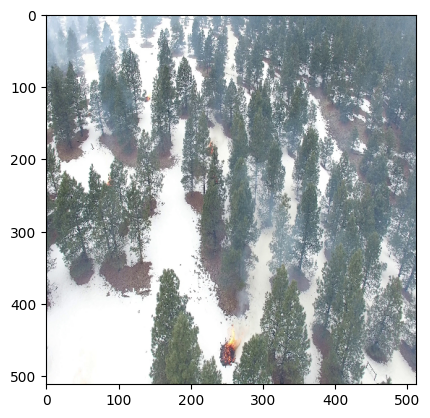

In [23]:

input_img_it =  test_dataset#.as_numpy_iterator()
for i in test_dataset.take(4):
    # print(i[0])
    input_img = i[0]
    input_gt = i[1]
    
plt.imshow(np.array(input_img[0]).astype(np.uint8))
mask = model.predict(np.array([input_img[0]]))

[0 1]
[3.1122238e-23 5.6318989e-23 1.0174077e-22 ... 9.9999523e-01 9.9999571e-01
 9.9999642e-01]


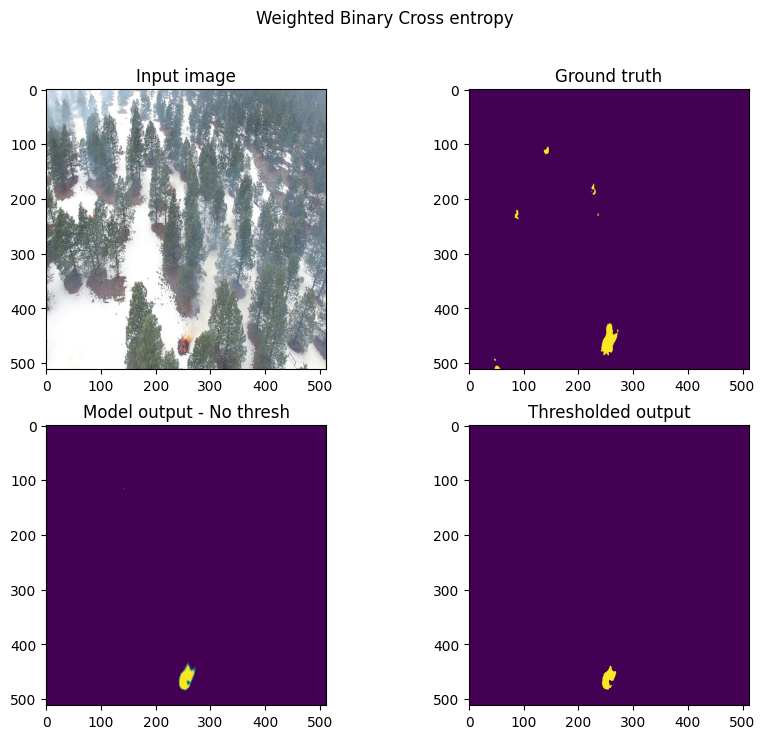

In [ ]:
fig,((ax1,ax2,),(ax3,ax4,)) = plt.subplots(2,2,figsize=(10,8))
fig.suptitle('Weighted Binary Cross entropy')

ax1.set_title('Input image')
ax1.imshow(np.array(input_img[0]).astype(np.uint8))

ax2.set_title('Ground truth')
ax2.imshow(input_gt[0])
print(np.unique(input_gt[0]))
ax3.set_title('Model output - No thresh')
ax3.imshow(mask[0])

ax4.set_title('Thresholded output')
threshed_mask = np.where(mask[0] < 0.9, 0, 1)
ax4.imshow(threshed_mask)

# plt.savefig('weighted_BCE-fig.png')


[(np.float32(0.66481334), np.float32(0.8932764)), (np.float32(0.63939637), np.float32(0.9189498)), (np.float32(0.62192214), np.float32(0.9422383)), (np.float32(0.61080223), np.float32(0.9517327)), (np.float32(0.59253377), np.float32(0.9588689)), (np.float32(0.5758538), np.float32(0.9653795)), (np.float32(0.55599684), np.float32(0.9776536)), (np.float32(0.5353455), np.float32(0.98682284))]


Text(0.5, 1.0, 'Precision-Recall curve')

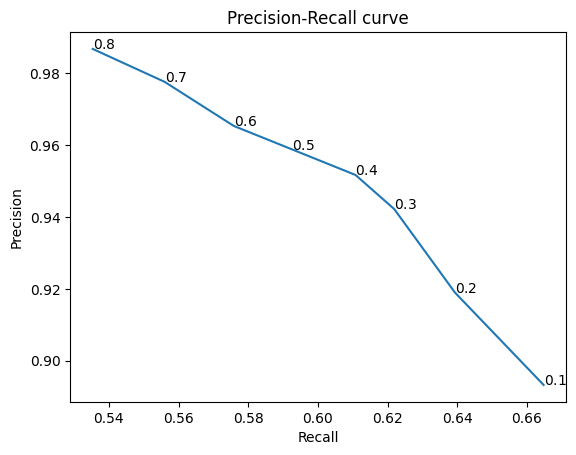

In [27]:
# -- precision recall

p_r_vals = []
thresh_vals = range(1,9,1)

def recall_m(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = tf.keras.ops.sum(y_true * y_pred)
    possible_positives = tf.keras.ops.sum(y_true)
    recall = true_positives / (possible_positives +tf.keras.backend.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    true_positives = tf.keras.ops.sum(y_true * y_pred)
    all_positives = tf.keras.ops.sum(y_pred)

    recall = true_positives / (all_positives +tf.keras.backend.epsilon())
    return recall
r_p=[]
for thresh in thresh_vals:

  threshed_mask = np.where(mask[0] <= thresh/10, 0, 1)
  r_p.append((tf.keras.backend.eval(recall_m(input_gt[0],threshed_mask)),
  tf.keras.backend.eval(precision_m(input_gt[0],threshed_mask))))
  plt.annotate(f'$0.{thresh}$',(r_p[-1][0],r_p[-1][1]))
plt.plot(*zip(*r_p))
print(r_p)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')

dict_keys(['accuracy', 'io_u_1', 'loss', 'mean_io_u_1', 'precision_1', 'recall_1', 'val_accuracy', 'val_io_u_1', 'val_loss', 'val_mean_io_u_1', 'val_precision_1', 'val_recall_1', 'learning_rate'])


<Figure size 640x480 with 0 Axes>

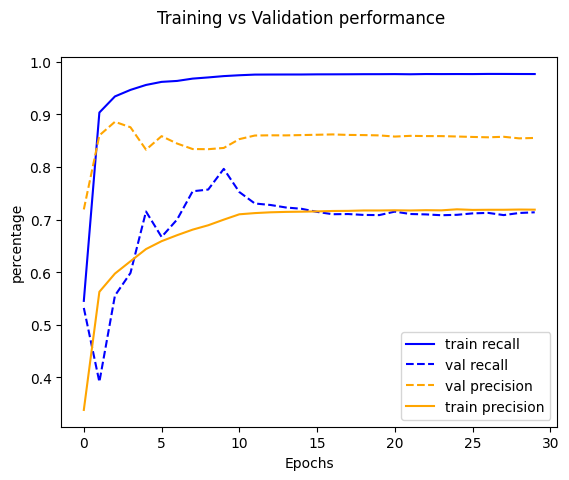

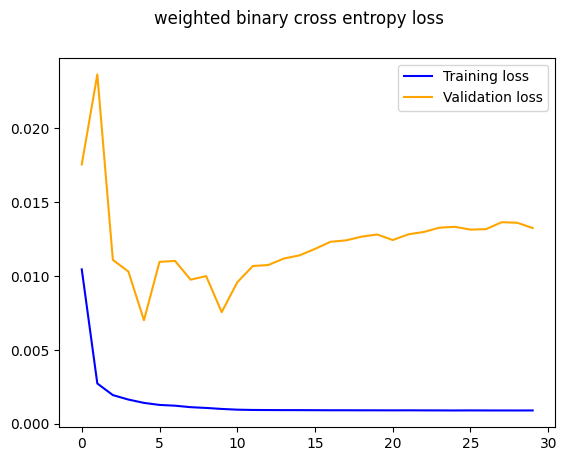

<Figure size 640x480 with 0 Axes>

In [29]:
import pickle
# with open('/content/drive/MyDrive/Colab Notebooks/Colab files/paper_unet_512_512_norm_wbce.history','rb') as f:
#     history = pickle.load(f)
print(history.keys())
metrics=['val_precision_1']
# plt.plot(history[metrics[0]])
plt.figure()
plt.plot(history['recall_1'], color='blue', label = 'train recall')
plt.plot(history['val_recall_1'], linestyle='dashed',color='blue',label = 'val recall')
plt.suptitle('Training vs Validation performance')
plt.xlabel('Epochs')
plt.ylabel('percentage')


plt.plot(history['val_precision_1'],  linestyle='dashed',color='orange',label = 'val precision')
plt.plot(history['precision_1'],color='orange',label = 'train precision')
plt.legend()
# plt.set_title('precision')
plt.figure()
plt.plot(history['loss'],color= 'blue', label = 'Training loss')
plt.plot(history['val_loss'],color = 'orange',label='Validation loss')
plt.legend()
plt.suptitle('weighted binary cross entropy loss')
plt.figure()

# Load and predict video

In [145]:
import  cv2
import timeit
def process_vid_frame(frame):   
    return tf.image.resize(frame,(TARGET_SIZE[0],TARGET_SIZE[1]))

vid = cv2.VideoCapture('1-Zenmuse_X4S_1.mp4')
width  = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))   # float `width`
height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))  # float `height`
fps = vid.get(cv2.CAP_PROP_FPS)
mask_vid = cv2.VideoWriter(filename='mask.mp4',fourcc=cv2.VideoWriter_fourcc(*'mp4v'),
                           fps = fps,frameSize = (512,512),isColor=False)
main_vid = cv2.VideoWriter(filename='vid.mp4',fourcc=cv2.VideoWriter_fourcc(*'mp4v'),
                           fps = fps,frameSize = (512,512),isColor=True)

#Streaming has some overhead
i=0
m_ar=[]
tmp_ar=[]
while (vid.isOpened() and i<5000):
    ret, frame = vid.read()
    print(i) if i%100 == 0 else None
    if i%5 == 0:
        input_img = process_vid_frame(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        mask_prediction = model.predict(input_img[None,...])
        mask_prediction = np.where(mask_prediction < 0.3, 0, 255)
        m_ar.append(input_img)
        tmp_ar.append(mask_prediction)
        main_vid.write( tf.keras.backend.eval(input_img)[...,::-1].astype(np.uint8))
        mask_vid.write(np.squeeze(mask_prediction).astype(np.uint8))
    
    i+=1

vid.release()
mask_vid.release()
main_vid.release()

0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


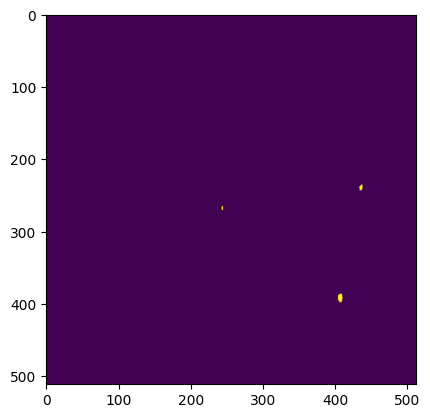

In [144]:
# plt.imshow(tmp_ar[0].astype(np.uint8))
plt.imshow(np.squeeze(np.where(model.predict(tf.keras.backend.eval(m_ar[-1][None,...]))<0.9,0,1)))



In [33]:
print(vid_array.shape)
inp = vid_array #[None, ...]
# print(inp.shape)
# # inp = tf.keras.utils
mask = model.predict(inp[175][None,...])
# # mask_vid.write(np.uint8(mask))
# mask.shape

(199, 512, 512, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


[9.7896381e-26 4.5483536e-25 4.7696355e-25 ... 9.9999690e-01 9.9999714e-01
 9.9999750e-01]


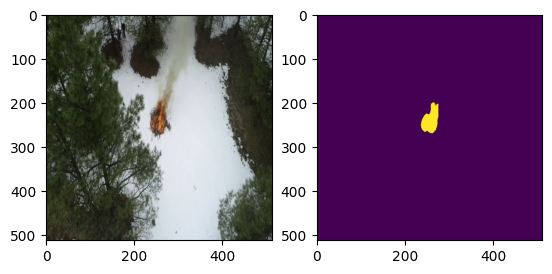

In [35]:
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(vid_array[175].astype(np.uint8))
print(np.unique(mask[0]))
threshed_mask = np.where(mask[0] < 0.5, 0, 1)

ax2.imshow(threshed_mask)

In [ ]:
vid = cv2.VideoCapture('mask.mp4')
mask_array = []
while vid.isOpened():
    ret,frame = vid.read()
    mask_array.append(frame)
vid.release()

: 

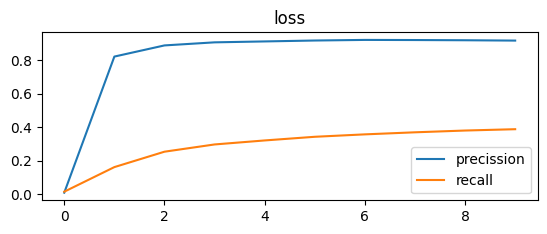

: 

In [ ]:
plt.subplot(212)
plt.title('loss')
plt.plot(history.history['precision'], label='precision')
plt.plot(history.history['recall'], label='recall')
plt.legend()
plt.show()

# 10 - TODO

1. Use cutouts, don't train on entire image